In [1]:
""" 
Try trained PCA on Gaussian embedding with categorical labels
"""

' \nTry trained PCA on embedding \n'

Simulation goals

* Study the transportation plan between different embedding spaces

* Specifically, we will simulate well-studied embeddings first, then simulate the features, and simulate labels

* Assume index starts from 1 in the simulation scheme

Simulation

* $l$: embedding dimension. $l=2$ in this simulation.

* $n$: total number of patients per domain

* $r \in \{1, 2\}$ for indexing domains

* $k \in [D]$ for indexing feature

* $i$ for indexing patient

* Generate relatively equal number of 1's and 2's for $Y_r$.

* Generate $E'_r$, the desired embedding space, in the following way, where $\epsilon$ is a random noise generator

    * When $r=1$, if $Y_{1i}$ is 1, $E'_{1i} = [-1, -1]+1.5\times\epsilon(E'_1)$  

    * When $r=1$, if $Y_{1i}$ is 2, $E'_{1i} = [1, 0]+2\times\epsilon(E'_1)$ 

    * When $r=2$, if $Y_{2i}$ is 1, $E'_{2i} = [-2, -2]+\epsilon(E'_2)$ 
    
    * When $r=2$, if $Y_{2i}$ is 2, $E'_{2i} = [2, 0]+2\times\epsilon(E'_2)$ 

* Train a PCA by simulation 1 features: $p$ stards for PCA transform, and $p^{-1} stands for PCA inverse transform.

* Generate features $X_r = p^{-1}\left(E'_r\right)$ 

After simulation

* Compute $\tilde{E'_2}$, the sinkhorn transported $E'_2$ onto $E'_1$

* Visualize $E'_1$, $E'_2$, $\tilde{E'_2}$ with class labels, check if it is the class are more seperated after transportation.



In [2]:
import sys
sys.path.append("/home/wanxinli/deep_patient/synthetic_exp")

from common import *
from deep_patient.sda import SDA
from math import floor, exp
import matplotlib.pylab as pl
import numpy as np
from numpy.random import poisson
from numpy.random import dirichlet
from random import randint
import theano.tensor as T
from sklearn import linear_model
from sklearn import svm
from sklearn import preprocessing
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA



WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


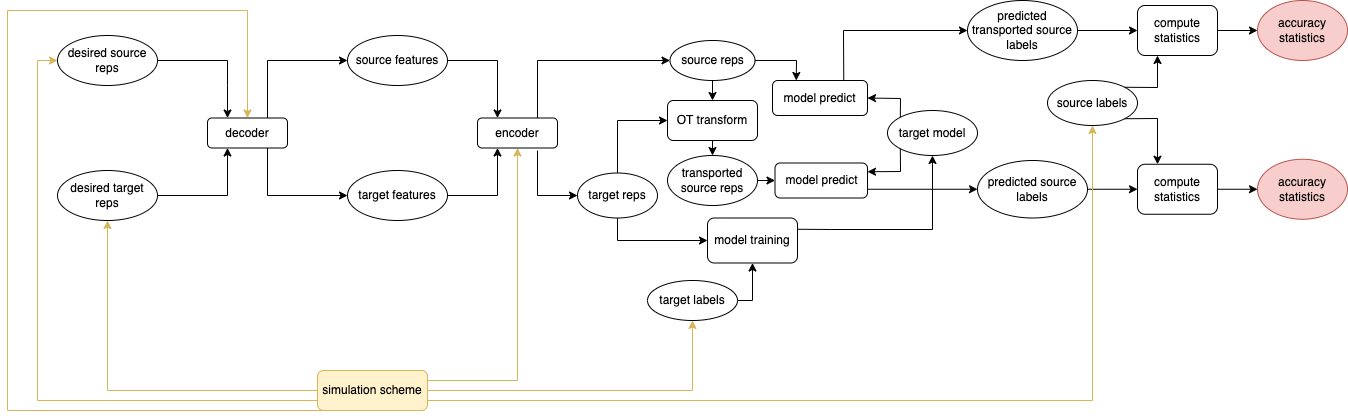

In [40]:
from IPython.display import Image
Image(filename='../outputs/EHR_emb_sim_pipeline.png')

In [3]:
""" 
Global parameter of this file
"""
pca = None

In [4]:
def simulate_emb_label(dataset, n, nz=.5, theta=0, p=.5, random_state=None, **kwargs):
    """ Simulate desired embeddings and labels
 
    Parameters
    ----------
    dataset : str
        type of classification problem (see code)
    n : int
        number of training samples
    nz : float
        noise level (>0)
    p : float
        proportion of one class in the binary setting
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Returns
    -------
    X : ndarray, shape (n, d), the desired embedding
        `n` observation of size `d`
    y : ndarray, shape (n,), the labels
        labels of the samples.
    """
    
    generator = check_random_state(random_state)

    if dataset.lower() == '2gauss': # this pair of simulation can be transported well
        y = np.floor((np.arange(n) * 1.0 / n * 2)) + 1
        x = np.zeros((n, 2))
        # class 1
        x[y == 1, 0] = -1
        x[y == 1, 1] = -1
        x[y == 2, 0] = 1
        x[y == 2, 1] = 0
        x[y != 2, :] += 1.5 * nz * generator.randn(sum(y != 2), 2)
        x[y == 2, :] += 2 * nz * generator.randn(sum(y == 2), 2)
    elif dataset.lower() == '2gauss2':
        y = np.floor((np.arange(n) * 1.0 / n * 2)) + 1
        x = np.zeros((n, 2))
        # class 1
        x[y == 1, 0] = -2.
        x[y == 1, 1] = -2.
        x[y == 2, 0] = 2.
        x[y == 2, 1] = 0.
        x[y != 2, :] += 1 * nz * generator.randn(sum(y != 2), 2)
        x[y == 2, :] += 2 * nz * generator.randn(sum(y == 2), 2)
        
    return x, y.astype(int)

In [5]:
""" 
Simulation scheme
"""

def simulate_pca_train(D, d_1, d_2, num_patient):
    """ 
    Simulate features and labels for domain 1 and domain 2, for PCA training
    :param int D:  total number of features
    :param int d_1: number of features with higher frequency in domain 1
    :param int d_2: number of features with higher frequency in domain 2
    :param int num_patient: number of patients in each domain

    Variables in the implementation are consistent with the variables in the scheme

    TODO: reconsider the choice of alpha_1 and alpha_2

    :return
        list[list[int]] domain 1 features
        list[int] domain 1 labels
        list[list[int]] domain 2 features
        list[int] domain 2 labels
    """

    d_1 = randint(0, floor(0.25*D))
    d_2 = randint(0, floor(0.25*D))
    delta_1 = np.random.choice(size = d_1, a = range(1, D+1), replace=False)
    remaining_set = list(set(list(range(1, D+1)))-set(delta_1))
    delta_2 = np.random.choice(size = d_1, a = remaining_set, replace=False)
    
    unit_1 = 1/(2*d_1-2*d_2+3*D)
    alpha_1 = [5*unit_1]*d_1
    alpha_1.extend([unit_1]*d_2)
    alpha_1.extend([3*unit_1]*(D-d_1-d_2))
  
    unit_2 = 1/(-2*d_1+2*d_2+3*D)
    alpha_2 = [unit_2]*d_1
    alpha_2.extend([5*unit_2]*d_2)
    alpha_2.extend([3*unit_2]*(D-d_1-d_2))  

    def gen_feature_vector_label(alpha):
        """ 
        Generate feature vectors and labels
        :param list[float] alpha: concentration parameteres for the dirichlet distribution
        """

        def sigmoid(x):
            return 1 / (1 + exp(-x))

        rho = dirichlet(alpha=alpha, size=1)[0]
        W = np.random.normal(size=D)
        W = [abs(W_k) for W_k in W] # only sample positive weights
        X = []
        Y = []
        b = 0
        all_sum = []

        for _ in range(num_patient):
            X_i = np.random.multinomial(len(rho), rho)
            for k in range(len(X_i)):
                if X_i[k] > 0:
                    X_i[k] = 1 # dominant effect
            X.append(X_i)
            cur_sum = np.sum(np.multiply(W, X_i))
            all_sum.append(cur_sum)
        
        # print("all_sum before preprocessing is:", all_sum)
        # standardize
        all_sum = preprocessing.scale(all_sum)
        # print("all_sum after preprocessing is:", all_sum)

        all_sum = np.array(all_sum)
        
        P = []
        for cur_sum in all_sum:
            p_i = sigmoid(cur_sum)
            P.append(p_i)
            Y_i = 0
            if p_i >= 0.5: # TODO: mimic exact logistic regression, change to np.random.binomial later
                Y_i = 1
            # Y_i = np.random.binomial(1, p_i) # too much noise, domain 1 data cannot learn well
            Y.append(int(Y_i))
        # print("P is:", P)

            
        return X, Y, W, b
    
    def feature_vector_to_feature(feature_vectors):
        """ 
        Convert feature vectors to features
        :param list[list[int]]: feature vectors consisting of indicators

        Returns
            - features consisting of actual codes
        """
        features = []
        for feature_vector in feature_vectors:
            features.append([i for i, e in enumerate(feature_vector) if e != 0])
        return features
    
    def pad_features(features_list):
        """ 
        Pad features to the same length (maximum length of the original features)\
            in each domain by -1
        """
        max_len = 0
        for features in features_list:
            max_len = max(max_len, len(features))

        for i in range(len(features_list)):
            features_list[i] += [-1] * (max_len - len(features_list[i]))
        return features_list



    feature_vector_1, label_1, W_1, b_1 = gen_feature_vector_label(alpha_1)
    feature_1 = pad_features(feature_vector_to_feature(feature_vector_1))
    feature_vector_2, label_2, W_2, b_2 = gen_feature_vector_label(alpha_2)
    feature_2 = pad_features(feature_vector_to_feature(feature_vector_2))
    return np.array(feature_1), label_1, np.array(feature_2), label_2



In [6]:
""" 
Wrapper function with different set ups for simulate()
"""
def simulate_pca_train_wrapper():
    num_patient = 1000
    D = 20
    d_1 = 8
    d_2 = 8
    return simulate_pca_train(D, d_1, d_2, num_patient)

In [7]:
def simulate_desired_emb_labels(num_patient):
    """ 
    Simulate target and source desired embedding space and labels
    """
    train_target_features, train_target_labels, _, _ = simulate_pca_train_wrapper()
    global pca
    pca = PCA(n_components=2)
    pca.fit(train_target_features)
    source_desired_reps, source_labels = simulate_emb_label('2gauss', num_patient)
    target_desired_reps, target_labels = simulate_emb_label('2gauss2', num_patient)
    trans_source_desired_reps = trans_source2target(source_desired_reps, target_desired_reps)

    return target_desired_reps, target_labels, source_desired_reps, source_labels


In [8]:
target_desired_reps, target_labels, source_desired_reps, source_labels = simulate_desired_emb_labels(100)
print(pca)

PCA(n_components=2)


/home/wanxinli/.local/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


In [9]:
def simulate(num_patient):
    target_desired_reps, target_labels, source_desired_reps, source_labels = simulate_desired_emb_labels(num_patient)
    
    target_features = pca.inverse_transform(target_desired_reps)
    target_features = [[int(code) for code in inner] for inner in target_features]
    source_features = pca.inverse_transform(source_desired_reps)
    source_features = [[int(code) for code in inner] for inner in source_features]
    source_reps = pca.transform(source_features)
    return target_features, target_labels, source_features, source_labels



In [10]:
def simulate_wrapper():
    return simulate(1000)

In [11]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features):
    """ 
    Customized training algorithm for generating target representations and source representations
    
    :returns: target representations, source representations
    """
    global pca
    target_reps = pca.transform(target_features)
    source_reps = pca.transform(source_features)

    return target_reps, source_reps


In [12]:
target_accuracies, target_precisions, target_recalls, target_f1s, \
    source_accuracies, source_precisions, source_recalls, source_f1s, \
    trans_source_accuracies, trans_source_precisions, trans_source_recalls, trans_source_f1s  = \
    run_proc_multi(simulate_wrapper, custom_train_reps, svm.SVC, max_iter=100000, n_times=100)

/home/wanxinli/.local/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/wanxinli/.local/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/wanxinli/.local/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/wanxinli/.local/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numIter

In [23]:
score_path = "../outputs/sim7_svm_scores.csv"
save_scores(target_accuracies, target_precisions, target_recalls, target_f1s, \
        source_accuracies, source_precisions, source_recalls, source_f1s, \
        trans_source_accuracies, trans_source_precisions, trans_source_recalls, trans_source_f1s, score_path)

average trans source to source accuracy increment is 7.4%
median trans source to source accuracy increment is 7.2%
average trans source to source accuracy f1 is 8.0%
median trans source to source accuracy f1 is 7.5%


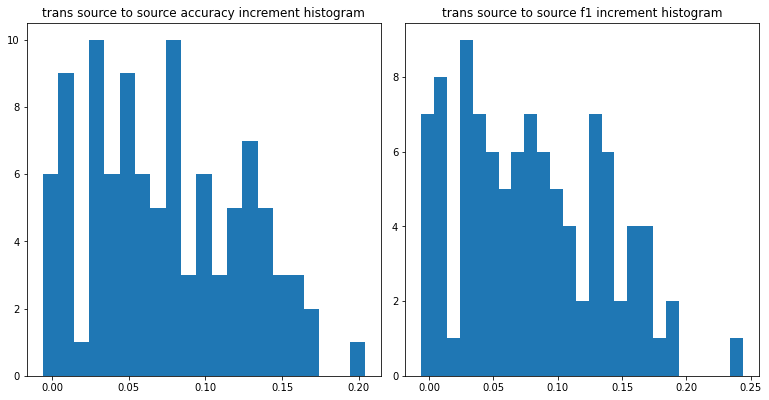

In [24]:
""" 
Larger is better (>0)
"""
hist_plot(score_path, filter=False)

In [25]:
""" 
One run with embedding space visualization
"""

' \nOne run with embedding space visualization\n'

In [33]:
train_target_features, train_target_labels, train_source_features, train_source_labels = simulate_pca_train_wrapper()

In [34]:
pca = PCA(n_components=2)
pca.fit(train_target_features)

source_desired_reps, source_labels = simulate_emb_label('2gauss', 1000)
target_desired_reps, target_labels = simulate_emb_label('2gauss2', 1000)

# Sinkhorn transport of desired source embedding into desired target embedding
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=100000)
ot_sinkhorn.fit(Xs=source_desired_reps, Xt=target_desired_reps)
trans_source_desired_reps = ot_sinkhorn.transform(Xs=source_desired_reps)


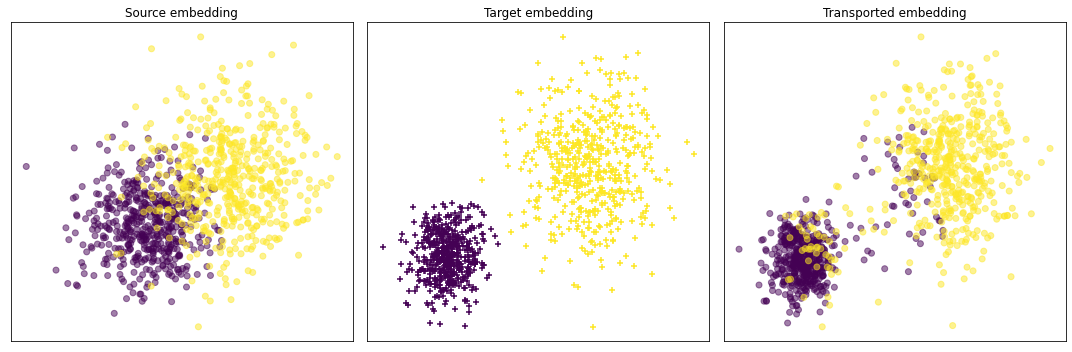

In [35]:
""" 
Visualize the desired embedding space
"""

vis_emb_dim2_unordered(target_desired_reps, target_labels, source_desired_reps, source_labels, trans_source_desired_reps)

In [36]:
target_features = pca.inverse_transform(target_desired_reps)
target_features = [[int(code) for code in inner] for inner in target_features]
target_reps = pca.transform(target_features)

source_features = pca.inverse_transform(source_desired_reps)
source_features = [[int(code) for code in inner] for inner in source_features]
source_reps = pca.transform(source_features)

# Sinkhorn Transport of source embedding into target embedding
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=100000)
ot_sinkhorn.fit(Xs=source_reps, Xt=target_reps)
trans_source_reps = ot_sinkhorn.transform(Xs=source_reps)

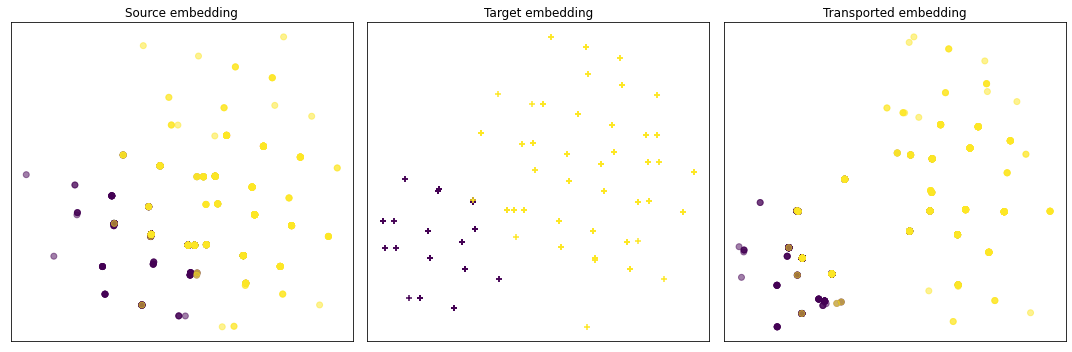

In [37]:
""" 
Visualize the actual embedding space
"""
vis_emb_dim2_unordered(target_reps, target_labels, source_reps, source_labels, trans_source_reps)

In [38]:
target_accuracy, target_precision, target_recall, target_f1, \
    source_accuracy, source_precision, source_recall, source_f1, \
    trans_source_accuracy, trans_source_precision, trans_source_recall, trans_source_f1 = \
    cal_stats_binary(target_reps, target_labels, source_reps, source_labels, \
    trans_source_reps, svm.SVC)

In [39]:
""" 
Print accuracy statistics
"""

print("source accuracy is:", source_accuracy, "source f1 is:", source_f1)
print("trans source accuracy is:", trans_source_accuracy, "trans source f1 is:", trans_source_f1)

source accuracy is: 0.819 source f1 is: 0.8157406361121884
trans source accuracy is: 0.892 trans source f1 is: 0.8919961118600269
